# Find and Link Similar Entities in Neptune: Deduplication

This notebook provides a code example for the blog post on finding and linking similar entities in Amazon Neptune. In this notebook we explore the DBLP/ACM publication dataset (https://doi.org/10.3886/E100843V2) linking publications and authors. There are numerous duplicate publications in this dataset. As we discuss in the blog post, these are detected and recorded using a machine learning algorithm called FindMatches (https://docs.aws.amazon.com/glue/latest/dg/machine-learning.html) during the ETL process, which runs in AWS Glue (https://aws.amazon.com/glue/).That process arranges the publications into a set of match groups. Publications within the same match group are similar and could be considered duplicates.

In an Amazon Neptune graph database, we wish to represent publications and their authors. Additionally, if a publication has duplicates, we wish to represent within the graph the presence of a match. 

Neptune supports labeled property graph or LPG (https://tinkerpop.apache.org/) and Resource Description Framework or RDF)(https://www.w3.org/RDF) representations of graph data. We use both here. Here is a depiction of our LPG model. 

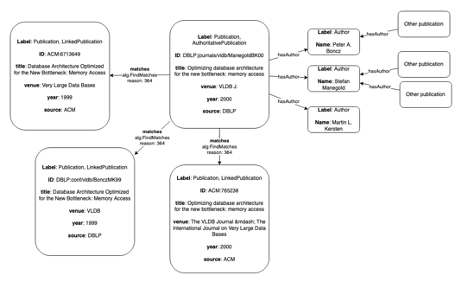 

Here is a summary of the model:

- Nodes are boxes; edges are arrows.
- Nodes are publications and authors.
- The hasAuthor edge points from publication to author to indicate authorship of the publication.  As shown, authors can publish other publications too. The value of the graph is that it allows us to navigate the web of author-publication relationships. 
- Publication nodes are labeled Publication . Within a match group, one publication is authoritative, and is labeled AuthoritativePublication. The others are labeled LinkedPublication, and there is a matches edges connecting the authoritative to the linked publication. By rule, the most recent DBLP publication in the group is considered authoritative.
- The matches edge has properties indicating algorithm (always FindMatches in our example) and reason (the match group ID). 

A publication dataset following this model with duplicate groups has already been prepared. If you are interested to explore how the data is prepared, see FindAndLink-DataPrep.ipynb. 

## Setup
This notebook requires a Neptune cluster and notebook instance. To create a development sandbox instance, follow the instructions in https://docs.aws.amazon.com/neptune/latest/userguide/get-started-cfn-create.html to provision a Neptune CloudFormation stack. Ensure you set the NotebookInstanceType input parameter to ensure a notebook instance is created. When complete, access Jupyter in the notebook instance, upload this notebook, and run through the steps below. 


## Load Publication Data
We use Neptune's bulk loader to load both Labeled Property Graph (LPG) and Resource Description Framework (RDF) representations of the dataset and its matches into the Neptune database. The source data is in a public S3 bucket. Run the cells that follow in sequence. The %load cells load the data from the S3 source. Wait for these to complete. They may take a few minutes. The %load_status cells check the results of the load. Check to ensure there are no errors.

In [141]:
%db_reset

Checkbox(value=False, description='I acknowledge that upon deletion the cluster data will no longer be availab…

Output()

In [134]:
%load -s s3://aws-neptune-customer-samples/neptune-ent-res/publications/dedup/pg --store-to loadres --run

Button(description='Submit', style=ButtonStyle())

Output()

In [ ]:
%load_status {loadres['payload']['loadId']} --errors --details

In [ ]:
%load -s s3://aws-neptune-customer-samples/neptune-ent-res/publications/dedup/rdf -f ntriples --store-to loadresrdf --run

In [ ]:
%load_status {loadresrdf['payload']['loadId']} --errors --details

## Explore LPG Data
### List some publication nodes and author nodes.
We'll run OpenCypher queries against Neptune database.

In [139]:
%%oc

MATCH(p:Publication)
RETURN p
LIMIT 10

In [ ]:
%%oc

MATCH(a:Author)
RETURN a
LIMIT 10

### Look at publications and their authors. 
Try the Graph view.

In [140]:
%%oc --d id

MATCH p=(n:Publication)-[:hasAuthor]->(a:Author)
RETURN p
LIMIT 200

### Look at publications and their relationships to authors plus other publications. 
Check out the graph view. You will see both "hasAuthor" and "matches" relationships.

In [ ]:
%%oc --d id

MATCH p=(n:Publication)-[*1..4]->()
RETURN p
LIMIT 100

### Find some linked publications and which publications they are linked to. 

In [ ]:
%%oc

MATCH(l:LinkedPublication)<-[m:matches]-(p:AuthoritativePublication)
RETURN p.title as Authoritative, p.title as Linked, m.matchAlg as alg, m.matchReason as matchGroup
LIMIT 20

### Look at some known duplicates

In [ ]:
%%oc 

MATCH (p:AuthoritativePublication)-[:hasAuthor]->(a:Author) ,(p)-[m:matches]->(lp:LinkedPublication)
WHERE id(p)='http://example.org/pubgraph/DBLP/journals/vldb/ManegoldBK00'

RETURN p.source, p.venue, p.year, p.title, 
m.matchReason, 
lp.source, lp.venue, lp.year, lp.title, 
collect(a.name) as authors 

## Explore RDF Data

The notebook also demonstrates a similar RDF model, which can be queried using SPARQL. In the linked data world of RDF, it is common to have resources from different sources representing the same thing but with different names and identifiers. 

In LPG, the matches edge has properties. In RDF, we use the qualified relation pattern. If linked publication :q matches authoritative publication :p, we represent as follows:

:q :hasMatch :uriOfPQMatch .
:uriOfPQMatch :hasLead :p .
:uriOfPQMatch :hasMatchSource :dedup .
:uriOfPQMatch :hasMatchAlgorithm :findMatches .
:uriOfPQMatch :matchReason {match group id} . 

There are two conventional ways to match resources in RDF. 

- *rdfs:seeAlso* indicates, in our example, that one publication gives more information about another publication. That information might include an alternate source, ID, title, venue, year. 
- *owl:sameAs* indicates that two resources refer to the same thing. This is a stronger link. It means that anything I could say about one publication I could say about the other publication.

We consider rdfs:seeAlso below.

### Look at publications and authors

Run SPARQL queries on the Neptune database.

In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

select * where {
    ?p a :Publication . 
    ?p :venue ?venue .
    ?p :year ?year .
    ?p :title ?title .
    ?p :hasSource ?source .
} 
LIMIT 100


In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

select * where {
    ?a a :Author . 
    ?a :name ?name .
} 
LIMIT 100


### Look at publications and their authors

In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

select ?p ?title (GROUP_CONCAT(distinct ?aname;SEPARATOR=",") AS ?authors) where {
    ?p a :Publication . 
    ?p :venue ?venue .
    ?p :year ?year .
    ?p :title ?title .
    ?p :hasSource ?source .
    ?a a :Author .
    ?p :hasAuthor ?a .
    ?a :name ?aname .
} 
GROUP by ?p ?title
ORDER BY ?p
LIMIT 100

### Look at publications and the ones they are linked to

In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

select ?p ?ptitle ?pyear ?pvenue ?lp ?ltitle ?lyear ?lvenue ?matchGroup where {
    ?lp a :LinkedPublication ; 
        :title ?ltitle ;
        :year ?lyear ;
        :venue ?lvenue ; 
        :hasMatch ?matcher .
    ?matcher :hasLead ?p ;
        #:hasMatchSource ?source ; - always dedup
        #:hasMatchAlgorithm ?alg ; - always FindMatches
        :matchReason ?matchGroup .
    ?p a :AuthoritativePublication ; 
        :title ?ptitle ; 
        :year ?pyear ; 
        :venue ?pvenue ; 
} 
ORDER by ?lp ?p
LIMIT 100


### Look at known matches

In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

select ?p ?ptitle ?pyear ?pvenue ?lp ?ltitle ?lyear ?lvenue ?matchGroup where {
    BIND (<http://example.org/pubgraph/DBLP/journals/vldb/ManegoldBK00> as ?p) .
    ?lp a :LinkedPublication ; 
        :title ?ltitle ;
        :year ?lyear ;
        :venue ?lvenue ; 
        :hasMatch ?matcher .
    ?matcher :hasLead ?p ;
        #:hasMatchSource ?source ; - always dedup
        #:hasMatchAlgorithm ?alg ; - always FindMatches
        :matchReason ?matchGroup .
    ?p a :AuthoritativePublication ; 
        :title ?ptitle ; 
        :year ?pyear ; 
        :venue ?pvenue ; 
} 
ORDER by ?lp ?p
LIMIT 100


### Add seeAlso

The above queries show that we represent matches in RDF using own own <http://example.org/pubgraph/hasMatch> predicate. We could also look at conventional ways in RDF of linking resources, notably rdfs:seeAlso. As described in https://www.w3.org/wiki/UsingSeeAlso, seeAlso relates a resource to another to provide further information about it. Indicating a match is a reasonable fit.

Let's add seeAlso relationships to our graph and then query for them.

In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

INSERT {
    ?lp rdfs:seeAlso ?p 
}
WHERE {
    ?lp a :LinkedPublication . 
    ?lp :hasMatch ?matcher .
    ?matcher :hasLead ?p .
} 


In [ ]:
%%sparql

PREFIX : <http://example.org/pubgraph/>

SELECT * WHERE {
    ?lp rdfs:seeAlso ?p 
}
LIMIT 100